## ThyrosimIM 
Adding an immune submodel to p-Thyrosim to simulate Hashimoto's thyroiditis. Before running, make sure to open REPL and `activate thyrosimIM` in pkg mode. Otherwise you can get some weird behavior where empty cells will run forever.

In [124]:
# Note that each cell will take quite a while to run the first time
using DifferentialEquations
using Plots

In [125]:
# Import files from src folder
# include("thyrosim_IM_odes.jl")
# include("utils.jl");

### ThyrosimIM

In [126]:
# No updates needed: p-Thyrosim individual scaling functions
"""
    plasma_volume(height, weight, sex, p)

# Parameters used to get reference plasma volume (Vp) values:
## MCL: NEED TO DOUBLE-CHECK HEIGHT/WEIGHT
## Blakesley data: half male, half female all of "normal weight and height" (but no values given in paper).
## height: Average height in USA.
## weight: I think we used approximate values from back-transforming it from BMI = 22.5?
    male_height   = 1.70
    female_height = 1.63
    male_weight   = 70.0
    female_weight = 59.0

The transform equation is `Vp_new = 3.2 * Vp_predicted / Vp_ref` where `Vp_ref` is 
the predicted Vp for the reference male/female patients. Thus, a reference
patient would have Vp_new = 3.2.

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female

# Optional inputs
+ `male_ref_vp`: male reference Vp
+ `female_ref_vp`: female reference Vp

# Outputs 
+ `Vp_new`: Scaled plasma volume (liters)
+ `Vtsh_new`: Scaled TSH distribution volume (liters)
"""
function plasma_volume(h, w, sex::Bool,
    Vtsh_scale = 1.0, ref_bmi = 22.5,
    male_ref_height = 1.7, female_ref_height=1.63
    )
    # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
    ref_Vp = (reference_Vp(ref_bmi, true, male_ref_height) + reference_Vp(ref_bmi, false, female_ref_height)) / 2
    Vp_new = predict_Vp(h, w, sex) * 3.2 / ref_Vp

    # scale Vtsh according to Vtsh_new = Vtsh_old + c(Vp_new - Vp_old) 
    Vtsh_new = 5.2 + Vtsh_scale * (Vp_new - 3.2)

    return Vp_new, Vtsh_new
end

"""
reference_Vp(ref_BMI::Float64, sex::Bool)

Calculates the "reference plasma volume" for Blakesleys patients with specified

Since the predicted plasma volume from Feldschush's data is not 3.2, this
reference volume is used to scale the predicted volume to 3.2. 
"""
function reference_Vp(ref_BMI::Float64, sex::Bool, ref_height::Float64)
    # calculate weight for specified ref_BMI. Ideal weight (iw) is fitted to Feldschush's data
    if sex
        iw = 176.3 - 220.6 * ref_height + 93.5 * ref_height^2
    else
        iw = 145.8 - 182.7 * ref_height + 79.55 * ref_height^2
    end
    w = ref_BMI * ref_height^2

    return predict_Vp(ref_height, w, sex)
end

"""
    predict_Vp(h, w, sex::Bool)

Computes the predicted plasma volume based on data fitted to Feldchush's data

# Inputs
+ `h`: height measured in meters
+ `w`: weight measured in KG 
+ `sex`: true = male, false = female
"""
function predict_Vp(h, w, sex::Bool)
    # hematocrit level, set to .45 for male and .4 for females
    Hem = 0.40 + 0.05 * sex

    # calculate Ideal Weight fitted to Feldschush's data
    if sex == 1
        iw = 176.3 - 220.6 * h + 93.5 * h^2
    elseif sex == 0
        iw = 145.8 - 182.7 * h + 79.55 * h^2
    end

    # power law fitted to Feldchush data
    a, n = 1.26975706e+03, 3.72981228e-01
    Δiw = (w - iw) / iw * 100  #deviation from ideal weight, in percentage
    Vb_per_kg = a * (100.0 + Δiw)^(n - 1)
    Vb = Vb_per_kg * w / 1000
    
    return Vb * (1 - Hem)
end

function blood_volume(h, w, sex::Bool)
    Hem = 0.40 + 0.05 * sex #.45 for male and .4 for females (by default)
    BMI = w / h^2

    # calculate Ideal Weight fitted to Feldschush's data
    if sex == 1
        iw = 176.3 - 220.6 * h + 93.5 * h^2
    elseif sex == 0
        iw = 145.8 - 182.7 * h + 79.55 * h^2
    end

    # power law fitted to Feldchush data
    a, n = 1.26975706e+03, 3.72981228e-01
    Δiw = (w - iw) / iw * 100  #deviation from ideal weight, in percentage
    Vb_per_kg = a * (100.0 + Δiw)^(n - 1)
    return Vb_per_kg * w / 1000
end;

In [127]:
# ThyrosimIM initial conditions and params... do not alter conditions here (see initialize_immune)
"""
initial conditions for thyrosimIM
"""
function initialize(
    dial::Vector{Float64} = [1.0; 0.88; 1.0; 0.88],
    scale_Vp::Bool = true,
    height=1.70,
    weight=70,
    sex=true; #true = male, false = female,
    fitting_index::Vector = Int[],         # needed in fitting
    p_being_optimized::Vector = Float64[], # needed in fitting
    fixed_parameters = Tuple[], # (a, b) means fix p[a] at b 
    scale_plasma_ode::Bool = false,
    scale_slow_ode::Bool = false,
    scale_fast_ode::Bool = false,
    scale_allometric_exponent::Bool = false,
    scale_clearance_by_gender::Bool = false,
    )

    # initial conditions
    ic    = zeros(Float64, 25)
    ic[1] = 0.322114215761171
    ic[2] = 0.201296960359917
    ic[3] = 0.638967411907560
    ic[4] = 0.00663104034826483
    ic[5] = 0.0112595761822961
    ic[6] = 0.0652960640300348
    ic[7] = 1.78829584764370
    ic[8] = 7.05727560072869
    ic[9] = 7.05714474742141
    ic[10] = 0
    ic[11] = 0
    ic[12] = 0
    ic[13] = 0
    ic[14] = 3.34289716182018
    ic[15] = 3.69277248068433
    ic[16] = 3.87942133769244
    ic[17] = 3.90061903207543
    ic[18] = 3.77875734283571
    ic[19] = 3.55364471589659

    # ---------- IMMUNE ICs ----------
    ic[20:25],_ = initialize_immune()

    # Parameter values
    p = zeros(Float64, 100) # you can add arbitrary amount of zeros as needed to fit more parameters
    p[1] = 0.0027785399344 #S4 (fitted)
    p[2] = 8               #tau
    p[3] = 0.868           #k12
    p[4] = 0.108           #k13
    p[5] = 584             #k31free
    p[6] = 1503            #k21free
    p[7] = 0.000289        #A
    p[8] = 0.000214        #B
    p[9] = 0.000128        #C
    p[10] = -8.83*10^-6    #D
    p[11] = 0.88           #k4absorb; originally 0.881
    p[12] = 0.0189         #k02
    p[13] = 0.012101809339 #VmaxD1fast (fitted)
    p[14] = 2.85           #KmD1fast
    p[15] = 6.63*10^-4     #VmaxD1slow
    p[16] = 95             #KmD1slow
    p[17] = 0.00074619     #VmaxD2slow
    p[18] = 0.075          #KmD2slow
    p[19] = 3.3572*10^-4   #S3
    p[20] = 5.37           #k45
    p[21] = 0.0689         #k46
    p[22] = 127            #k64free
    p[23] = 2043           #k54free
    p[24] = 0.00395        #a
    p[25] = 0.00185        #b
    p[26] = 0.00061        #c
    p[27] = -0.000505      #d
    p[28] = 0.88           #k3absorb
    p[29] = 0.184972339613 #k05 (fitted)
    p[30] = 450            #Bzero (fixed so max TSH is about 1000)
    p[31] = 219.7085301388 #Azero (fitted)
    p[32] = 0              #Amax (set to 0 because 1976 weeke says hypothyroid patients should have no oscillations)
    p[33] = -3.71          #phi
    p[34] = 0.53           #kdegTSH-HYPO
    p[35] = 0.226          #VmaxTSH (originally it's 0.037 but this is probably a typo because eq4 of 2010 eigenberg it not a real hill function)
    p[36] = 23             #K50TSH
    p[37] = 0.058786935033 #k3 (fitted)
    p[38] = 0.29           #T4P-EU
    p[39] = 0.006          #T3P-EU
    p[40] = 0.037          #KdegT3B
    p[41] = 0.0034         #KLAG-HYPO
    p[42] = 5              #KLAG
    p[43] = 1.3            #k4dissolve
    p[44] = 0.12           #k4excrete; originally 0.119 (change with dial 2)
    p[45] = 1.78           #k3dissolve
    p[46] = 0.12           #k3excrete; originally 0.118 (change with dial 4)
    p[47] = 3.2            #Vp
    p[48] = 5.2            #VTSH

    #parameters for hill functions in f_circ and SRtsh
    p[49] = 3.001011022378 #K_circ (fitted)
    p[50] = 3.094711690204 #K_SR_tsh (fitted)
    p[51] = 5.674773816316 #n, hill exponent in f_circ (fitted)
    p[52] = 6.290803221796 #m, hill exponent in SR_tsh (fitted)
    p[53] = 8.498343729591 #K_f4 for f4 (fitted)
    p[54] = 14.36664496926 #l, hill exponent for f4 (fitted)

    # p[55] = 0.0 # T4 oral dose
    # p[56] = 0.0 # T3 oral dose

    # dial parameters 
    p[57] = dial[1] # controls T4 secretion rate
    p[58] = dial[2] # controls T4 excretion rate
    p[59] = dial[3] # controls T3 secretion rate
    p[60] = dial[4] # controls T3 excretion rate

    # variance parameters for T4/T3/TSH and schneider error (these are used only for parameter estimation!)
    p[61] = 5.003761571969437   # σ for T4 in Blakesley (fixed to reasonable value before fitting)
    p[62] = 0.11122955089297369 # σ for T3 Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[63] = 0.4                 # σ for TSH in Blakesley and Jonklaas (fixed to reasonable value before fitting)
    p[64] = 0.1                 # σ for FT4 in Jonklaas (fixed to reasonable value before fitting)

    # Blakesley reference BMI
    p[65] = 21.82854404275587 # (male, fitted)
    p[66] = 22.99050845201536 # w / h^2 (female, fitted)

    # Vtsh scaling factor
    p[67] = 1.0 

    # extra parameter
    # p[68] = 22.5 # w / h^2 (female)

    # Volume scaling ratio
    p[69] = 1.0 # Plasma volume ratio
    p[70] = -1.0 # Plasma volume (forgot what this is supposed to represent)
    p[71] = 1.0 # allometric exponent for plasma volume

    # slow compartment scaling ratio
    p[72] = 1.0 # fat-free constant
    p[73] = 0.0 # fat constant
    p[74] = 1.0 # scaling ratio for slow compartment

    # fast compartment scaling ratio
    p[75] = 1.0

    # allometric exponent for k05 
    p[76] = 0.75 # for male (fixed)
    p[77] = 0.75 # for female (fixed, 0.75 works well)

    # ref height for male and female
    p[78] = 1.7608716659237555 # (fitted)
    p[79] = 1.6696106891941103 # (fitted)

    # clearance scale (male / female)
    p[80] = 1.0499391485135692 # male clearance (fitted)

    # infusion parameters
    p[81] = 0.0 # T4 infusion
    p[82] = 0.0 # T3 infusion

    # ----------- IMMUNE PARAMETERS ----------
    _, p[83:100] = initialize_immune()
 

    # change fitting parameters
    if length(fitting_index) > 0
        p[fitting_index] .= p_being_optimized
    end

    # scale plasma parameters
    ref_bmi = sex ? p[65] : p[66]
    if scale_plasma_ode
        # for now, assume male and females have the same ref Vp (ie average male/female ref Vp)
        ref_Vp = (reference_Vp(ref_bmi, true, p[78]) + reference_Vp(ref_bmi, false, p[79])) / 2
        p[69] = predict_Vp(height, weight, sex) / ref_Vp
    end
    scale_allometric_exponent && (p[71] = 0.75)

    # scale slow compartment
    if scale_slow_ode
        ref_weight = sex ? p[65] * p[78]^2 : p[66] * p[79]^2
        ref_fat_free_mass = reference_fat_free_mass(sex, male_ref_height=p[78], female_ref_height=p[79])
        ref_fat_mass = ref_weight - ref_fat_free_mass
        slow_compartment_scale = (p[72] * fat_free_mass(sex, height) + p[73] * (weight - fat_free_mass(sex, height))) / 
            (p[72] * ref_fat_free_mass + p[73] * ref_fat_mass)
        p[74] = slow_compartment_scale
    end

    # scale fast compartment
    scale_fast_ode && (p[75] = 1.0)

    if scale_Vp
        Vp, Vtsh = plasma_volume(height, weight, sex, p[67], ref_bmi, p[78], p[79])
        p[47] = Vp
        p[48] = Vtsh
    end

    clearance_allometric_exp = sex ? p[76] : p[77]
    if scale_clearance_by_gender
        ref_weight = sex ? p[65] * p[78]^2 : p[66] * p[79]^2
    else
        ref_weight = (p[65] * p[78]^2 + p[66] * p[79]^2) / 2
    end
    p[29] *= (weight / ref_weight)^clearance_allometric_exp
    sex && (p[29] *= p[80]) # scale male k05 by prefactor

    # fix parameters declared by users
    for (a, b) in fixed_parameters
        p[a] = b
    end

    return ic, p
end;


In [128]:
# ThyrosimIM ODE SYSTEM
"""
ODEs for thyroid-immune compartmental model thyrosimIM. 
"""
function thyrosimIM(dq, q, p, t)
    kdelay = 5/8

    # scaling the mass/concentration of compartments
    plasma_volume_ratio = p[69]^p[71]
    slow_volume_ratio = p[74]^p[71]
    fast_volume_ratio = p[75]^p[71]

    # scale comparment sizes
    q1 = q[1] * 1 / p[69]
    q2 = q[2] * 1 / p[75]
    q3 = q[3] * 1 / p[74]
    q4 = q[4] * 1 / p[69]
    q5 = q[5] * 1 / p[75]
    q6 = q[6] * 1 / p[74]
    q7 = q[7] * 1 / p[69]

    # Auxillary equations
    q4F = (p[24]+ p[25] * q1 + p[26] * q1^2 + p[27] * q1^3) * q4 #FT3p
    q1F = (p[7] + p[8] * q1 + p[9] * q1^2 + p[10] * q1^3) * q1  #FT4p
    SR3 = (q[24]/p[100])*(p[19] * p[59] * q[19]) # Scaled (q[24]/p[100]) Brain delay (dial 3)
    SR4 = (q[24]/p[100])*(p[1] * p[57] * q[19])  # Scaled (q[24]/p[100]) Brain delay (dial 1)
    fCIRC = q[9]^p[51] / (q[9]^p[51] + p[49]^p[51])
    SRTSH = (p[30]+p[31]*fCIRC*sin(pi/12*t-p[33]))*(p[50]^p[52]/(p[50]^p[52] + q[9]^p[52]))
    fdegTSH = p[34] + p[35] / (p[36] + q7)
    fLAG = p[41] + 2*q[8]^11 / (p[42]^11 + q[8]^11)
    f4 = p[37]*(1 + 5*(p[53]^p[54]) / (p[53]^p[54]+q[8]^p[54]))
    NL = p[13] / (p[14] + q2)

    # ODEs
    dq[1]  = p[81] + (SR4 + p[3] * q2 + p[4] * q3 - (p[5] + p[6]) * q1F) * plasma_volume_ratio + p[11] * q[11] #T4dot (need to remove u1)
    dq[2]  = (p[6] * q1F - (p[3] + p[12] + NL) * q2) * fast_volume_ratio                                    #T4fast
    dq[3]  = (p[5] * q1F -(p[4] + p[15] / (p[16] + q3) + p[17] /(p[18] + q3)) * q3) * slow_volume_ratio  #T4slow
    dq[4]  = p[82] + (SR3 + p[20] * q5 + p[21] * q6 - (p[22] + p[23]) * q4F) * plasma_volume_ratio + p[28] * q[13] #T3pdot
    dq[5]  = (p[23] * q4F + NL * q2 - (p[20] + p[29]) * q5) * fast_volume_ratio                         #T3fast
    dq[6]  = (p[22] * q4F + p[15] * q3 / (p[16] + q3) + p[17] * q3 / (p[18] + q3) -(p[21])*q6) * slow_volume_ratio #T3slow
    dq[7]  = (SRTSH - fdegTSH * q7) * plasma_volume_ratio                                           #TSHp
    dq[8]  = f4 / p[38] * q1 + p[37] / p[39] * q4 - p[40] * q[8]          #T3B
    dq[9]  = fLAG * (q[8] - q[9])                                             #T3B LAG
    dq[10] = -p[43] * q[10]                                                   #T4PILLdot
    dq[11] =  p[43] * q[10] - (p[44] * p[58]+ p[11]) * q[11]                  #T4GUTdot: note p[44] * p[58] = p[44] * dial[2] = k4excrete
    dq[12] = -p[45] * q[12]                                                   #T3PILLdot
    dq[13] =  p[45] * q[12] - (p[46] * p[60] + p[28]) * q[13]                 #T3GUTdot: note p[46] * p[60] = p[46] * dial[4] = k3excrete

    # Delay ODEs -- why do we have so many chained together like this??
    dq[14] = kdelay * (q7 - q[14]) 
    dq[15] = kdelay * (q[14] - q[15])                                         #delay2: TSH delay
    dq[16] = kdelay * (q[15] - q[16])                                         #delay3
    dq[17] = kdelay * (q[16] - q[17])                                         #delay4
    dq[18] = kdelay * (q[17] - q[18])                                         #delay5
    dq[19] = kdelay * (q[18] - q[19])                                         #delay6

    # ---------- IMMUNE ODEs ---------- q[20:Bcell, 21:Pcell, 22:Tcell, 23:Cytokine, 24:FTS, 25:TPOAb]
    # q = q+19
    # p = p+82
    dq[20] = p[83]*(q[23]/(q[23]+p[95]))*q[22]+p[97]*q1F-(p[89]+p[84])*q[20] # Bdot
    dq[21] = p[84]*q[20]-p[90]*q[21] # Pdot
    dq[22] = p[85]*q[24]+p[98]*(q[23]/(q[23]+p[96]))*q[22]-p[91]*q[22] # Tdot
    dq[23] = p[86]*q[22]-p[92]*q[23] # Cdot
    dq[24] = p[87]*((q7/q[24])*p[100])-p[93]*(q[24])*q[25] #p[87]*((q7/q[24])*p[100])-p[93]*(q[24]/p[100])*q[25] # FTSdot MODIFIED
    dq[25] = p[88]*q[21]-q[25]*(p[94]+p[93]*q[24]) # Abdot

end;

In [129]:
# Set initial conditions if warmup is enabled (run 30 days prior to plotting)
"""
Set initial conditions from data. Options to set other compartments to steady state,
optionally including the TSH lag compartments.
"""
function set_patient_ic!(ic, p, t4, t3, tsh;
        steady_state::Bool=false, set_tsh_lag::Bool=false)
    # Set IC for observed compartments. 
    ic[1] = (p[47] * t4) / 777.0
    ic[4] = (p[47] * t3) / 651.0
    ic[7] = (p[48] * tsh) / 5.6
    
    if steady_state
        q4F = (p[24]+ p[25] * ic[1] + p[26] * ic[1]^2 + p[27] *ic[1]^3) * ic[4] #FT3p
        q1F = (p[7] + p[8] * ic[1] + p[9] * ic[1]^2 + p[10] * ic[1]^3) * ic[1]  #FT4p
        
        B = p[6] * q1F - p[14] * (p[3] + p[12]) - p[13]
        A = -(p[3] + p[12])
        C = p[6] * p[14] * q1F
        ic[2] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        B = p[5] * q1F - (p[4] + p[15] / p[16]) * p[18] - p[17]
        A = -(p[4] + p[15] / p[16])
        C = p[5] * p[18] * q1F
        ic[3] = (-B - sqrt(B^2 - 4.0 * A *C)) / (2.0 * A)
        
        ic[5] = (p[23] * q4F + (p[13] / (p[14] + ic[2])) * ic[2]) / (p[20] + p[29])
        ic[6] = (p[22] * q4F + p[15] * (ic[3] / (p[16] + ic[3]))
            + p[17] * (ic[3] / (p[18] + ic[3]))) / p[21]
    end
    
    if set_tsh_lag
        # Probably not 100% correct since they're supposed to be lagged, but probably better than the default.
        ic[14:19] .= ic[7]
    end
end

"""
Find initial conditions from approximate steady state solution. 

This function runs a Thyrosim simulation for 30 days and sets the initial 
contidion `ic` to the ending values for each compartment.
"""
function find_patient_ic!(ic, p, days; model = thyrosimIM)
    tspan = (0.0, 24.0 * days)
    prob = ODEProblem(model, ic, tspan, p)
    sol = solve(prob)
    ic .= sol[end]
end

# Figure 2 of Heymsfield 2007: https://academic.oup.com/ajcn/article/86/1/82/4633194
function adipose_tissue_free_mass(sex::Bool, h::Real) #true = male, false = female, height h in meter
    h_cm = 100h
    sex ? 0.0006 * h_cm^2.21 : 0.001 * h_cm^2.1 # unit kg
end

# Figure 3 of Heymsfield 2007: https://academic.oup.com/ajcn/article/86/1/82/4633194
function fat_free_mass(sex::Bool, h::Real) #true = male, false = female, height h in meter
    h_cm = 100h
    sex ? 0.0004 * h_cm^2.3 : 0.0019 * h_cm^1.97 # unit kg
end

function reference_fat_free_mass(sex::Bool; male_ref_height=1.7, female_ref_height=1.63)
    h = sex ? male_ref_height : female_ref_height # avg male/female height
    return fat_free_mass(sex, h) # unit kg
end

# Table 2 of Muler 2011: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0022732
function liver(w::Real, h::Real) # w in kg, h in meter
    return 0.088 * w^0.54 * h^1.04
end
function kidney(w::Real, h::Real)
    return 0.012 * w^0.72 * h^0.19
end

kidney (generic function with 1 method)

In [130]:
# ----------------------- Immune Subsystem -------------------------

"""
 Set parameters for the immune subsystem. Note all rates and times are in seconds
 Will need to scale immune compartment to day timescale
"""
# function initialize_immune() #OLD VERSION

#     ic = zeros(6)
#     ic[1] = 100
#     ic[2] = 80
#     ic[3] = 805
#     ic[4] = 6.022e15
#     ic[5] = 11
#     ic[6] = 3.122e6

#     p = zeros(18)
#     p[1] = 1 # B-cell activation rate, will probably be lower due to T3 term p[15]
#     p[2] = 3 # Plasma cell transformation rate
#     p[3] = 8.05 # CD4+ activation rate
#     p[4] = 51.84 # Cytokine production rate
#     p[5] = 1e7 # relative growth rate of FTS
#     p[6] = 1e4 # combined antibody production rate
#     p[7] = 2e-7 # B-cell death rate
#     p[8] = 4.0e-7 # Plasma cell death rate
#     p[9] = 8.91e-7 # CD4+ cell death rate
#     p[10] = 0.189  # Cytokine degredation rate
#     p[11] = 1e-3 # Functional thyroid destruction rate
#     p[12] = 1.74e-6 # Blood Ab degredation rate
#     p[13] = 18e4 # B-cell cytokine binding activation threshold
#     p[14] = 2e4 # CD4+ T-cell cytokine binding activation threshold
#     p[15] = 1e3 # NOTE: NEED TO FIT and CHANGE
#     p[16] = 9.1e-3 # CD4+ T-cell stimulation rate
#     # p[17] = 0.25 # Maximum thyroid growth ratio
#     p[18] = 13.5 # Euthyroid FTS

#     return ic, p
# end

function initialize_immune()

    ic = zeros(6)
    ic[1] = 100 # B-cells
    ic[2] = 20 # Plasma cells 
    ic[3] = 300 # CD4+ cells
    ic[4] = 15e9 # Cytokines
    ic[5] = 3 # FTS
    ic[6] = 1.5e9 # Antibodies

    p = zeros(18)
    p[1] = 3e-3 # B-cell activation rate, will probably be lower due to T3 term p[15]
    p[2] = 1e-2 # Plasma cell transformation rate
    p[3] = 8.05e-1 # CD4+ activation rate
    p[4] = 51.84e5 # Cytokine production rate
    p[5] = 1e6 # relative growth rate of FTS
    p[6] = 1e6 # combined antibody production rate
    p[7] = 2e-6 # B-cell death rate
    p[8] = 4.0e-2 # Plasma cell death rate
    p[9] = 8.91e-3 # CD4+ cell death rate
    p[10] = .189  # Cytokine degredation rate
    p[11] = 1e-2 # Functional thyroid destruction rate
    p[12] = 1.74e-3 # Blood Ab degredation rate
    p[13] = 18e5 # B-cell cytokine binding activation threshold
    p[14] = 2e6 # CD4+ T-cell cytokine binding activation threshold
    p[15] = 1e3 # NOTE: NEED TO FIT and CHANGE
    p[16] = 9.1e-4 # CD4+ T-cell stimulation rate
    # p[17] = 0.25 # Maximum thyroid growth ratio
    p[18] = 13.5 # Euthyroid FTS

    return ic, p
end

initialize_immune (generic function with 1 method)

In [131]:
# Plotting functions

function output_plot(sol; title::AbstractString = "ThyrosimIM simulation", automargins::Bool=true)

    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    if automargins
        t4lim = max(1.2maximum(T4), 130.0)
        t3lim = max(1.2maximum(T3), 2.5)
        tshlim = max(1.2maximum(TSH), 5.5)
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), label="",
       ylabel="T4 (mcg/L)", title=title)
    p1 = hline!([45, 120], label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), label="", 
       ylabel="T3 (mcg/L)")
    p2 = hline!([0.6, 1.8], label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), label="",
       ylabel="TSH (mU/L)", xlabel="time [days]")
    p3 = hline!([0.45, 4.5], label= "")
    
    plot(p1, p2, p3, layout=(3, 1))
end

function output_plotIM(sol; title::AbstractString = "ThyrosimIM simulation", automargins::Bool=true)

    # can definitley clean up this code quite a bit later (looped plotting, get rid of unnecessary plots...)
    # parameters to adjust figure limits
    p = sol.prob.p 
    t4lim, t3lim, tshlim = 140, 4, 10
    T4 = 777.0 * sol[1, :] / p[47]
    T3 = 651.0 * sol[4, :] / p[47]
    TSH = 5.6 * sol[7, :] / p[48]
    Bcell = sol[20, :]
    PlasmaCell = sol[21, :]
    CD4Cell = sol[22, :]
    Cytokines = sol[23, :]/6.022e11 # convert to nM from molecules/mL
    FTS = sol[24, :]
    TPOAb = sol[25, :]/6.022e8 # convert to pM from molecules/mL

    xlim=(0,sol.t[end]/24) 
    if automargins
        t4lim = max(1.2maximum(T4), 130.0)
        t3lim = max(1.2maximum(T3), 2.5)
        tshlim = max(1.2maximum(TSH), 5.5)
        Blim = 1.2maximum(Bcell)
        Plim = 1.2maximum(PlasmaCell)
        Tlim = 1.2maximum(CD4Cell)
        Clim = 1.2maximum(Cytokines)
        Flim = 1.2maximum(FTS)
        Alim = 1.2maximum(TPOAb)
    end

    p1 = plot(sol.t / 24.0, T4, ylim=(0, t4lim), xlim=xlim, label="", ylabel="T4 (mcg/L)")
    p1 = hline!([45, 120], label= "")
    
    p2 = plot(sol.t / 24.0, T3, ylim=(0, t3lim), xlim=xlim, label="", ylabel="T3 (mcg/L)", title=title)
    p2 = hline!([0.6, 1.8], label= "")
    
    p3 = plot(sol.t / 24.0, TSH, ylim=(0, tshlim), xlim=xlim, label="", ylabel="TSH (mU/L)")
    p3 = hline!([0.45, 4.5], label= "")

    p4 = plot(sol.t / 24.0, Bcell, ylabel="Bcell (cell/mL)", ylim=(0,Blim), xlim=xlim, label="")
    p5 = plot(sol.t / 24.0, PlasmaCell, ylabel="Plasma Cell (cell/mL)", ylim=(0,Plim), xlim=xlim, label="")
    p6 = plot(sol.t / 24.0, CD4Cell, ylabel="CD4+ Cell (cell/mL)", ylim=(0,Tlim), xlim=xlim, label="")
    p7 = plot(sol.t / 24.0, Cytokines, ylabel="Cytokines (nM)", xlabel="time [days]", ylim=(0,Clim), xlim=xlim, label="")
    p8 = plot(sol.t / 24.0, FTS, ylabel="Functional Thyroid Size (mL)", xlabel="time [days]", ylim=(0,Flim), xlim=xlim, label="")
    p9 = plot(sol.t / 24.0, TPOAb, ylabel="TPOAb (pM)", xlabel="time [days]", ylim=(0,Alim), xlim=xlim, label="")

    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout=(3, 3))

end


output_plotIM (generic function with 1 method)

In [132]:
# Simulate Function
"""
    simulate(h, w, sex, ...)

Simulate a person of known height, weight, and gender for 30 days (default).

If `warmup = true`, will first run the model for 30 days, assuming healthy
thyroid function, to get approximate initial condition. 

Note: The last 5 parameters are optional scaling parameters, but in our final model,
only `scale_plasma_ode` and `scale_clearance_by_gender` are set to `true`. Thus only 
these 2 are true by default. 
"""
function simulate(
    h::Real, # units meters
    w::Real, # units kg
    sex::Bool; # true = male, false = female
    days::Int=30, 
    dial=[1.0; 0.88; 1.0; 0.88], 
    T4dose::Real=0.0, # mcgs
    T3dose::Real=0.0, # mcgs
    dosing_interval::Real=24.0, #hours
    warmup::Bool = true,
    fitting_index = Int[],
    parameters = Float64[],
    fixed_parameters=Tuple{Int64,Float64}[],
    scale_plasma_ode=true,
    scale_slow_ode=false,
    scale_fast_ode=false,
    scale_allometric_exponent = false,
    scale_clearance_by_gender = true,
    )
    function add_dose!(integrator)
        integrator.u[10] += integrator.p[55]
        integrator.u[12] += integrator.p[56]
    end
    cbk = PeriodicCallback(add_dose!, dosing_interval) 

    # initialize thyrosimIM parameters
    ic, p = initialize(dial, true, h, w, sex, 
        fitting_index=fitting_index, p_being_optimized=parameters,
        fixed_parameters=fixed_parameters,
        scale_plasma_ode=scale_plasma_ode, scale_slow_ode=scale_slow_ode,
        scale_fast_ode=scale_fast_ode,
        scale_allometric_exponent=scale_allometric_exponent,
        scale_clearance_by_gender=scale_clearance_by_gender)
    p[fitting_index] .= parameters

    # run simulation for 30 days to get approximate steady state conditions
    # this assumes healthy patient without dose
    warmup && find_patient_ic!(ic, p, 30) 

    # setup daily dosing and fitting parameters 
    p[55] = T4dose / 777.0 # daily dose
    p[56] = T3dose / 651.0 # daily dose
    p[57:60] .= dial #set dial

    # solve and return ode solution
    prob = ODEProblem(thyrosimIM,ic,(0.0, 24days),p,callback=cbk)
    return solve(prob)
end;


In [133]:
# Patient characteristics
sex = true
h = 1.73
w = 72.8;

## Simulation

In [134]:
sol = simulate(h,w,sex,days=30, warmup=false);

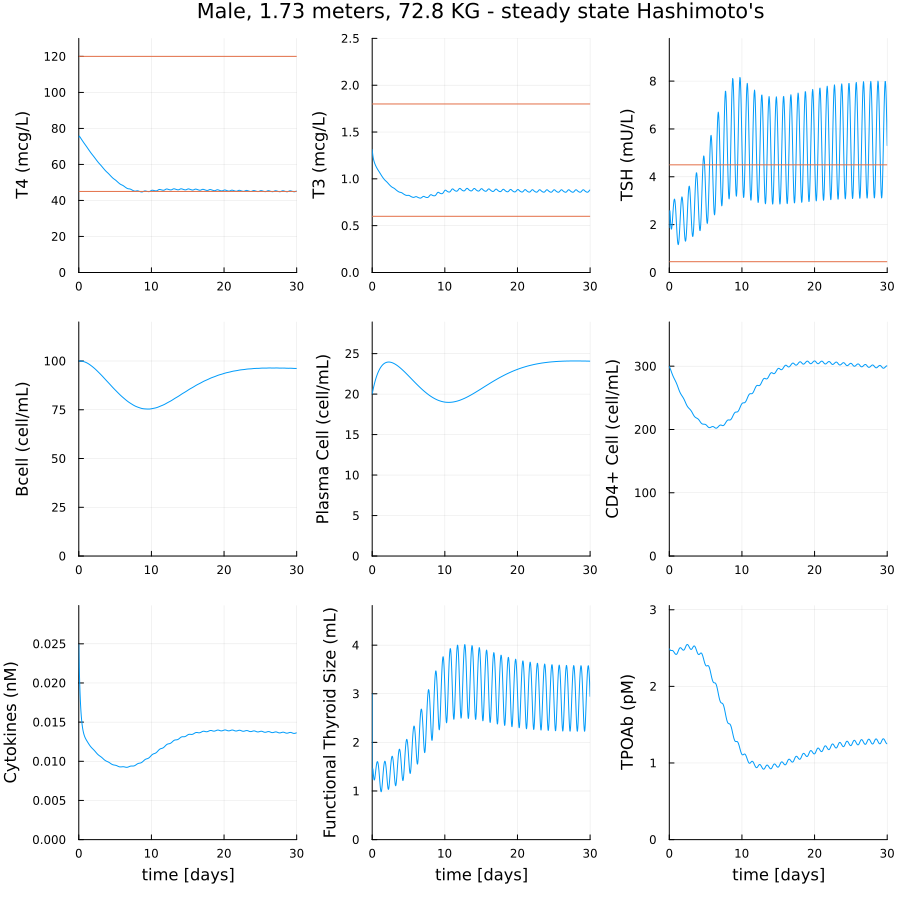

In [135]:
plt = output_plotIM(sol, title="Male, $h meters, $w KG - steady state Hashimoto's")

### Steady state values

In [136]:
# Steady state values for ICs
# ic, p = initialize([1.0; 0.88; 1.0; 0.88], true, h, w, sex)
# steady_state_values = find_patient_ic!(ic, p, 30)
# Uncomment below to print values
# for (i, value) in enumerate(steady_state_values)
#     println("ic[",i  ,"] = ", value)
# end

### Sample Data Generation

In [137]:
using Distributions, CSV, DataFrames

# Extract solution data and format into matrix
T4 = hcat(sol.u...)[1, :]
T3 = hcat(sol.u...)[4, :]
TSH = hcat(sol.u...)[7, :]
Immune_data = hcat(sol.u...)[20:25, :]
Bcells = Immune_data[1,:]
Plasma = Immune_data[2,:]
CD4 = Immune_data[3,:]
Cytokine = Immune_data[4,:]
FTS = Immune_data[5,:]
Ab = Immune_data[6,:]

# Construct dataframe with entries to be fit
df = DataFrame(t=sol.t, T4=T4, T3=T3, TSH=TSH,
               Bcells=Bcells, Plasma=Plasma, CD4=CD4,
               Cytokine=Cytokine, FTS=FTS, Ab=Ab)

# Multiply each entry by some random gaussian curve
for col in names(df)
    if col != "t"
        for i in 1:size(df[!,col])[1]
            df[!, col][i] *= rand(Normal(1, 0.05))
        end
    end
end

# Subsample every 10th row
sample_data = df
indices = 1:10:size(sample_data, 1)
sample_data = sample_data[indices, :]

# Save as CSV file
CSV.write("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sample_IM.csv", sample_data)

"C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sample_IM.csv"

In [159]:
# Data deletion to emulate inconsistent patient information 
function sparsify_data(data::DataFrame, percentage; columns=names(data))
    n = round(Int, percentage * nrow(data))
    df = DataFrame()
    df[!, columns[1]] = data[!, columns[1]]
    
    for column in columns[2:end]
        total_indicies = 1:nrow(data)
        missing_indices = sort(unique(rand(total_indicies, n)))
        kept_indicies = setdiff(total_indicies, missing_indices)
        new_col = Union{Number, Missing}[missing for i in total_indicies]
        length(missing_indices) + length(kept_indicies) != nrow(data) && println("setdiff error: missing = ", length(missing_indices),
        "\tkept: ", length(kept_indicies), "\ttotal: ", nrow(data))
        # potentially problematic
        for i in kept_indicies
            new_col[i] = data[!, column][i]
        end
        df[!, column] = new_col
    end

    return df
end

sparse_data = sparsify_data(sample_data, 0.1)
CSV.write("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sparse_sample10.csv", sparse_data)

"C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sparse_sample10.csv"

### Data Visulaization

In [160]:
# Import sample data
loaded_sparse_data = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sparse_sample10.csv"));
loaded_full_data = DataFrame(CSV.File("C:/Users/Aidan/Documents/GitHub/BioCyb/thyrosimIM/data/sample_IM.csv"));

In [161]:
function plot_estIM(data)

    tvals = data.t./24

    p1 = scatter(tvals, data.T4, ylabel="T4 (mcg/L)")    
    p2 = scatter(tvals, data.T3, ylabel="T3 (mcg/L)")    
    p3 = scatter(tvals, data.TSH, ylabel="TSH (mU/L)")
    p4 = scatter(tvals, data.Bcells, ylabel="Bcell (cell/mL)")
    p5 = scatter(tvals, data.Plasma, ylabel="Plasma Cell (cell/mL)")
    p6 = scatter(tvals, data.CD4, ylabel="CD4+ Cell (cell/mL)")
    p7 = scatter(tvals, data.Cytokine, ylabel="Cytokines (nM)")
    p8 = scatter(tvals, data.FTS, ylabel="Functional Thyroid Size (mL)")
    p9 = scatter(tvals, data.Ab, ylabel="TPOAb (pM)")

    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout=(3, 3))

end

function compare_data(sample1, sample2)

    tvals = data.t./24
    
    p1 = scatter(tvals, sample1.T4, ylabel="T4 (mcg/L)", color=:darkorchid)
    p1 = scatter!(tvals, sample2.T4, ylabel="T4 (mcg/L)", color=:lightblue, alpha=0.5)        
    p2 = scatter(tvals, sample1.T3, ylabel="T3 (mcg/L)", color=:darkorchid)    
    p2 = scatter!(tvals, sample2.T3, ylabel="T3 (mcg/L)", color=:lightblue, alpha=0.5)    
    p3 = scatter(tvals, sample1.TSH, ylabel="TSH (mU/L)", color=:darkorchid)
    p3 = scatter!(tvals, sample2.TSH, ylabel="TSH (mU/L)", color=:lightblue, alpha=0.5)
    p4 = scatter(tvals, sample1.Bcells, ylabel="Bcell (cell/mL)", color=:darkorchid)
    p4 = scatter!(tvals, sample2.Bcells, ylabel="Bcell (cell/mL)", color=:lightblue, alpha=0.5)
    p5 = scatter(tvals, sample1.Plasma, ylabel="Plasma Cell (cell/mL)", color=:darkorchid)
    p5 = scatter!(tvals, sample2.Plasma, ylabel="Plasma Cell (cell/mL)", color=:lightblue, alpha=0.5)
    p6 = scatter(tvals, sample1.CD4, ylabel="CD4+ Cell (cell/mL)", color=:darkorchid)
    p6 = scatter!(tvals, sample2.CD4, ylabel="CD4+ Cell (cell/mL)", color=:lightblue, alpha=0.5)
    p7 = scatter(tvals, sample1.Cytokine, ylabel="Cytokines (nM)", color=:darkorchid)
    p7 = scatter!(tvals, sample2.Cytokine, ylabel="Cytokines (nM)", color=:lightblue, alpha=0.5)
    p8 = scatter(tvals, sample1.FTS, ylabel="Functional Thyroid Size (mL)", color=:darkorchid)
    p8 = scatter!(tvals, sample2.FTS, ylabel="Functional Thyroid Size (mL)", color=:lightblue, alpha=0.5)
    p9 = scatter(tvals, sample1.Ab, ylabel="TPOAb (pM)", color=:darkorchid)
    p9 = scatter!(tvals, sample2.Ab, ylabel="TPOAb (pM)", color=:lightblue, alpha=0.5)
    

    plot!(size=(900,900))
    plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout=(3, 3))

end

compare_data (generic function with 1 method)

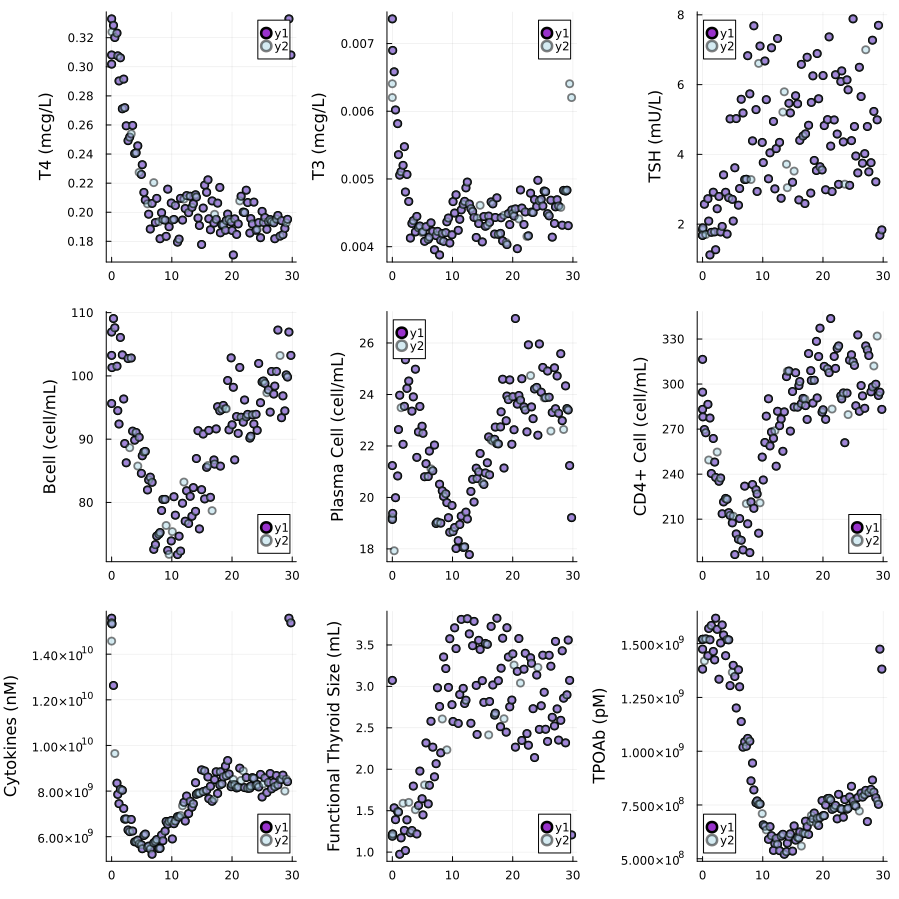

In [162]:
compare_data(loaded_sparse_data, loaded_full_data)

In [165]:
119*0.9^9

46.10303819100001